d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)
C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_20720\3520928829.py:41: RuntimeWarning: Mean of empty slice
  emi_effects[j,e] = np.nanmean(Xnan_after - Xnan_before, axis=0)
C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_20720\3520928829.py:43: RuntimeWarning: Mean of empty slice
  predicted_effects[j,e] = np.nanmean((predicted_after - Xnan_before), axis=0)
d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\ZI Mannheim\Control Theory\project_EMIcompass\.venv\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value e

Absolute prediction item mean: mean R^2=0.45801051902681233, sem R^2=0.2830879055317403
Difference prediction: r=0.8815765160099452, p=6.333633173631178e-18, R^2=0.7771771535802332


C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_20720\3520928829.py:61: RuntimeWarning: Mean of empty slice
  predicted_effects = np.nanmean(predicted_effects, axis=0)
C:\Users\janik.fechtelpeter\AppData\Local\Temp\ipykernel_20720\3520928829.py:62: RuntimeWarning: Mean of empty slice
  emi_effects = np.nanmean(emi_effects, axis=0)


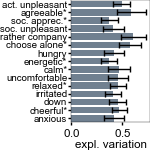

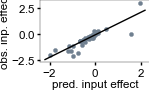

In [1]:
from ctrl import utils
from ctrl.discrete_optimal_control2 import LQR
import custom_rcparams_paper as crc
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import sem
import os

os.makedirs('figures', exist_ok=True)

data = utils.load_data()
N = len(data)
n_feat = len(data[0]['Xlabs'])
n_emis = len(data[0]['Ilabs'])
determination_coeff = np.zeros((N, n_feat))
r_squared = np.zeros((N, n_feat))
emi_effects = np.zeros((N, n_emis, n_feat))
predicted_effects = np.zeros((N, n_emis, n_feat))
Xpred = []

for j in range(len(data)):
    A = data[j]['A']
    B = data[j]['C']
    X = data[j]['X']
    Xnan = data[j]['Xnan']
    U = data[j]['Inp']

    prediction = LQR.step(A, B, X, U)[:-1]
    Xpred.append(prediction)

    mask = np.isnan(Xnan[:-1])
    prediction[mask] = np.nan

    determination_coeff[j] = 1 - (np.nansum((prediction - Xnan[1:])**2, axis=0) 
                                  / np.nansum((np.nanmean(Xnan[1:], axis=0, keepdims=True) - Xnan[1:])**2, axis=0))

    for e in range(n_emis):
        Xnan_before = Xnan[:-1][U[:-1,e]==1]
        Xnan_after = Xnan[1:][U[:-1,e]==1]
        emi_effects[j,e] = np.nanmean(Xnan_after - Xnan_before, axis=0)
        predicted_after = prediction[U[:-1,e]==1]
        predicted_effects[j,e] = np.nanmean((predicted_after - Xnan_before), axis=0)

    for f in range(n_feat):
        mask = ~np.isnan(Xnan[1:][:,f]) & ~np.isnan(prediction[:,f])
        r_squared[j,f] = np.corrcoef(prediction[mask,f], Xnan[1:][mask, f])[0,1]**2

with mpl.rc_context({'ytick.labelsize':'x-small'}):
    fig, ax = plt.subplots(1,1, figsize=(1.5,1.5))
    ax.barh(range(n_feat), np.nanmean(r_squared, axis=0), color=crc.colors.features,
                xerr=sem(r_squared, axis=0, nan_policy='omit'), error_kw={'linewidth':1}, ecolor=crc.colors.errorbars)
    ax.set_yticks(np.arange(n_feat), labels=data[0]['Xlabs'])
    ax.set_ylim((-0.5, n_feat-0.5))
    ax.set_xlabel('expl. variation')
    fig.savefig('figures/figure1C.png')


fig, ax = plt.subplots(1,1,figsize=(1.5,0.9))
predicted_effects[np.isnan(emi_effects)] = np.nan
predicted_effects = np.nanmean(predicted_effects, axis=0)
emi_effects = np.nanmean(emi_effects, axis=0)
ax, corr = utils.plot_regression(predicted_effects.flatten(), emi_effects.flatten(), 
                      scatter_kwargs={'color':crc.colors.standard}, line_kwargs={'color':'k'}, ax=ax,
                      nan_policy='omit')
ax.set_xlabel('pred. input effect')
ax.set_ylabel('obs. inp. effect')

fig.savefig('figures/figure1D.png')

print(f"Absolute prediction item mean: mean R^2={np.nanmean(r_squared)}, std R^2={np.nanstd(r_squared)}")
print(f'Difference prediction: r={corr.statistic}, p={corr.pvalue}, R^2={corr.statistic**2}')